# Title: gentzkowChanDataTask {-}
# Author: Daniel Cohen, UC Berkeley {-}
# Date: 11/25/20 {-}
# Description: Data task for Gentzkow/Chan lab position {-}

*NOTE: I consciously decided to embed my code within the answers document and not separate the two. I believe my work and answers are more valuable if their validity can immediately be assessed alongside the code that produced them. However, please know that if I were tasked with producing this document and you asked me to split up the report and the code, I could do so very quickly (five to ten minutes). I would only produce a report like this in an employee-employer or student-mentor check-in context, and I recognize that this format would be less useful if I were, say, presenting my results to a group.*

## (00) Preliminary work {-}

### Import required libraries {-}

In [24]:
import pandas as pd                                # for data manipulation
import numpy as np                                 # for useful numerical functions
import matplotlib.pyplot as plt                    # plotting
import seaborn as sns                              # nice-looking plotting
from statsmodels.api import OLS, add_constant      # ordinary-least-squares regression
import datetime as dt                              # datetime manipulation

### Read in data {-}

In [12]:
visits = pd.read_csv('test_data.txt')

### Convert time columns into more useful non-string format {-}

In order to best summarize data, and for the purposes of the rest of the task, I begin converting data into useful format now 

In [13]:
# start by converting ed_tc, dcord_tc into datetime

visits['ed_tc'] = pd.to_datetime(visits['ed_tc'])
visits['dcord_tc'] = pd.to_datetime(visits['dcord_tc'])

# add column for visit length (as float, number of hours);
# I also include column for visit length as datetime, since this is useful for summary

visits['visit_length_dt'] = visits['dcord_tc'] - visits['ed_tc']
visits['visit_length'] = (visits['visit_length_dt'].dt.components['hours'] + 
                          (visits['visit_length_dt'].dt.components['minutes'] / 60))

In [14]:
# extract shift start and end datetimes 

visits[['shift_start_date', 'shift_start_time', 'shift_start_ampm',
        'shift_end_time', 'shift_end_ampm']] = (visits['shiftid']
                                                     .str.replace('to ', "")
                                                     .str.replace('noon', '12 p.m.')
                                                     .str.split(" ", expand=True))

visits['shift_start'] = pd.to_datetime((visits[['shift_start_date', 'shift_start_time', 'shift_start_ampm']]
                                        .agg(' '.join, axis=1)))
visits['shift_end_tentative'] = pd.to_datetime((visits[['shift_start_date', 'shift_end_time', 'shift_end_ampm']]
                                                .agg(' '.join, axis=1)))

In [15]:
# in cases where this process yields shift end times that are greater than shift start times,
# this indicates the shift went into the next day and thus we add one day to the shift end time

visits['shift_end'] = np.where(visits['shift_start'] < visits['shift_end_tentative'],
                               visits['shift_end_tentative'],
                               visits['shift_end_tentative'] + pd.DateOffset(days=1))

In [16]:
# select only relevant columns 

visits = visits.loc[:, ['ed_tc', 'dcord_tc', 'xb_lntdc', 'visit_length', 'visit_length_dt',
                        'shiftid', 'shift_start', 'shift_end', 'phys_name', 'visit_num']]

In [17]:
# add columns for shift length (as float, number of hours)

visits['shift_length'] = (visits['shift_end'] - visits['shift_start']).dt.components['hours']

In [18]:
# add column for expected length of stay (non-log), so it can be easily compared to 
# real length of stay below 

# NOTE: I am assuming xb_lntdc is in units of HOURS and refers to NATURAL LOG, although
#       this is not specified in the description.

visits['xb_tdc'] = np.exp(visits['xb_lntdc'])

## (0) Data summary {-}

In [19]:
# standard summaries for numerical variables

visits[['xb_lntdc', 'xb_tdc', 'visit_length_dt']].describe()

,xb_lntdc,xb_tdc,visit_length_dt
count,8831.000000,8831.000000,8831
mean,1.121157,3.269433,0 days 04:02:28.216510
std,0.381810,1.042913,0 days 04:13:02.547943
min,-0.275887,0.758899,-1 days +22:11:00
25%,1.006444,2.735854,0 days 01:43:00
50%,1.202871,3.329663,0 days 02:51:00
75%,1.382665,3.985511,0 days 04:36:00
max,2.124072,8.365131,1 days 12:51:00


There do appear to be at least some entries that are data entry errors. For example, the minimum visit length is -1 days and 22 hours, which implies that the patient left almost two days before they arrived (clearly en error). This has nothing to do with the phenomenon in (1).

Another example of a potential data entry error or algorithmic calculation error on the hospital's end is that the minimum predicted length of stay is negative, which also doesn't make any sense.

One point of interest (that does not fall under the category of "error") is that expected visit length and real visit length have similar averages, but real visit length has a standard deviation that is 3-4 times higher. Since real visit times are theoretically limited below at zero, this should indicate that the distribution of real visit times has a much longer right tail. This is shown in the distribution plot below. It is also interesting to note that the expected visit time is bimodal; this indicates the potential existence of a binary variable that significantly shifts the expectation. For example, perhaps women tend to have shorter visits than men, so the first mode is most common for women and the second mode is most common for men.

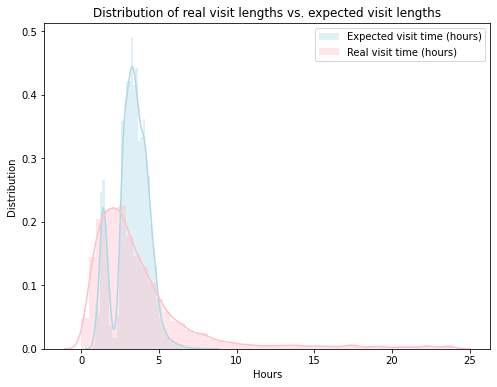

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(visits['xb_tdc'], norm_hist=True, color='lightblue', label='Expected visit time (hours)', ax=ax);
sns.distplot(visits['visit_length'], norm_hist=True, color='pink', label='Real visit time (hours)', ax=ax);
plt.legend();
plt.title('Distribution of real visit lengths vs. expected visit lengths');
plt.xlabel('Hours');
plt.ylabel('Distribution');

In [21]:
# summarize shift lengths by creating dataframe with one row per shift, 
# so as to not over-count shifts with more patients in the original dataset

visits.groupby(['phys_name', 'shiftid'])[['shift_length']].agg(np.mean).describe()

,shift_length
count,530.000000
mean,9.073585
std,0.430699
min,2.000000
25%,9.000000
50%,9.000000
75%,9.000000
max,10.000000


Quickly surveying this summary, there do not appear to be obvious errors in shift reporting (e.g., exorbitantly long/short or negative-length shifts).

## (1) Shift starts and ends {-}

In [25]:
# before continuing, I remove the 4 observations with negative visit time

visits = visits.loc[visits['visit_length_dt'] > dt.timedelta(minutes=1)]

In [27]:
visits['outside_shift'] = np.where((visits['ed_tc'] < visits['shift_start']) |
                                   (visits['dcord_tc'] > visits['shift_end']),
                                   1,
                                   0)

In [28]:
percent_outside_shift = np.round((sum(visits['outside_shift']) / len(visits)) * 100, 2)
print(f"Percent outside shift: {percent_outside_shift}%")

Percent outside shift: 25.67%


We can see that 25.67% of patients either arrive before their physician's shift begins or leave after their physician's shift ends.

## (2) Patterns of patient arrivals {-}

### Hourly patterns of patient arrivals {-}

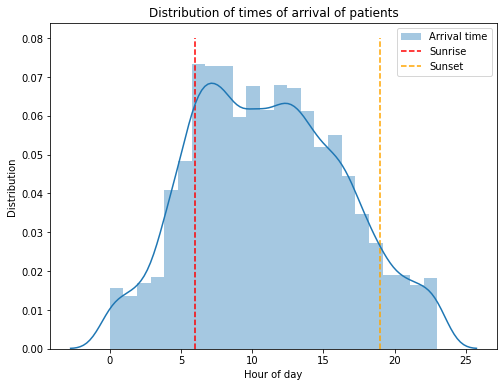

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.distplot(visits['ed_tc'].dt.hour, norm_hist=True, label='Arrival time', ax=ax, bins=24);
plt.xlabel('Hour of day');
plt.ylabel('Distribution');
plt.title('Distribution of times of arrival of patients');

plt.vlines(6, ymin=0, ymax=0.08, ls = '--', color='red', label='Sunrise');
plt.vlines(19, ymin=0, ymax=0.08, ls = '--', color='orange', label='Sunset');

plt.legend();

Above is a distribution plots of the hours of arrival of patients in the dataset (in standard/military time). The red dotted line corresponds to sunrise at 6 AM (my arbitrarily-determined start of the day), and the orange dotted line corresponds to sunset at 7 PM (my arbitrarily-determined end of the day). 

The most interesting trends here are: first, a vast majority of patients arrive in the daytime (between sunrise and sunset); second, patient visits are most common early in the day, and then slowly diminish until sunset; third, there is still an uptick in patients between the wee hours of the night (e.g., 3 AM) and the very early morning (5 AM).

### Patient severity {-}

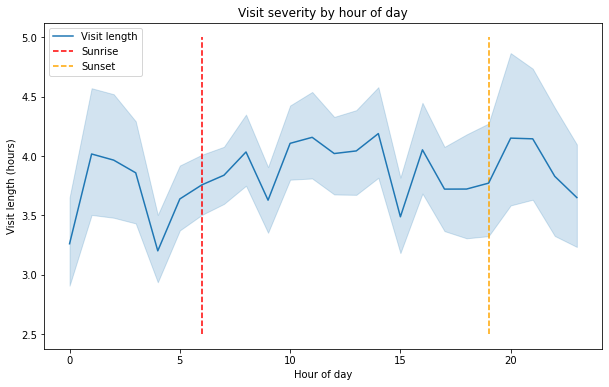

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

severity_by_hr = visits.groupby(visits['ed_tc'].dt.hour)['visit_length'].agg([np.mean, np.std])

sns.lineplot(x=visits['ed_tc'].dt.hour, y=visits['visit_length'], ci=95, ax=ax, label='Visit length');
plt.title('Visit severity by hour of day');
plt.xlabel('Hour of day');
plt.ylabel('Visit length (hours)');

plt.vlines(6, ymin=2.5, ymax=5, ls = '--', color='red', label='Sunrise');
plt.vlines(19, ymin=2.5, ymax=5, ls = '--', color='orange', label='Sunset');

plt.legend(loc='upper left');

There does not appear to be significant or consistent correlation between time of day and visit length. This conclusion is particularly true when taking the error bands into consideration, which are relatively wide. One could maybe argue that average visit length is slightly higher just after sundown and just before sunrise than at other times.

One could test the hypothesis that patient severity is predicted by time of day by performing a linear regression and observing the standard error on the coefficients. This regression could take multiple forms depending on the desired interpretation. One could treat the times as continuous, and observe if larger hours of the day correspond to longer wait times, but this approach doesn't make much sense because time is not linear. A more logical approach would be regressing patient severity against a binary indicator of day vs. night (for maximum power), or early day vs. late day vs. early night vs. late night (for more granularity) and observing if the resulting coefficients are significant.

## (3) Census {-}

This question should require less legwork, as I have already produced most of the fields in the preliminary portion of the assignment. 

### Create census dataset {-}

In [31]:
# define column for each visit's hour of shift by subtracting the shift start time 
# from the patient arrival time. 

# NOTE: this does not yet take into account the desired indexing

visits['start_shift_hour'] = (visits['ed_tc'] - visits['shift_start']).dt.components['hours']
visits['end_shift_hour'] = (visits['dcord_tc'] - visits['shift_start']).dt.components['hours']

# produce desired indexing by subtracting the length of the shift

visits['start_shift_hour'] = visits['start_shift_hour'] - visits['shift_length']
visits['end_shift_hour'] = visits['end_shift_hour'] - visits['shift_length']

In [32]:
# produce census dataset by iterating over all possible combinations 
# of phyician, shift, and time.

# NOTE: I am aware this is not the most efficient approach, but given our small dataset
#       and the time-sensitive nature of this assignment, I believe this is a reasonable
#       setting for inefficient but effective preliminary code. 

physicians = pd.unique(visits['phys_name'])
rows = []

for p in physicians:
    shifts = pd.unique(visits.loc[visits['phys_name'] == p, 'shiftid'])
    
    for s in shifts: 
        relevant_visits = visits.loc[(visits['phys_name'] == p) & (visits['shiftid'] == s)]
        s_len = int(np.mean(relevant_visits['shift_length']))
        
        for t in range(-s_len, 4):
            num_patients = len(relevant_visits[(relevant_visits['start_shift_hour'] <= t) & 
                                               (relevant_visits['end_shift_hour'] >= t)])
            rows.append([s, p, t, num_patients])


In [33]:
census = pd.DataFrame(rows, columns=['shiftid', 'phys_name', 'index', 'n'])

In [34]:
census.to_csv('census.csv', index=False)

### Census vs. time {-}

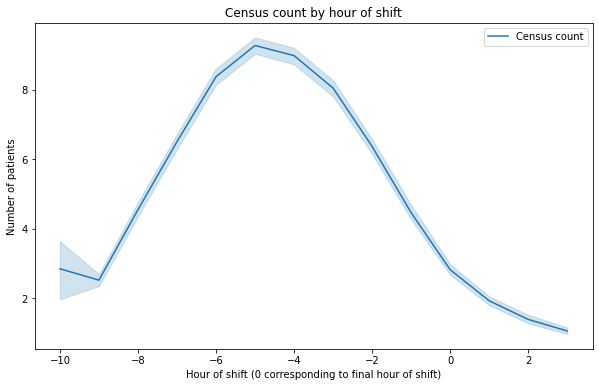

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

census_by_hr = census.groupby('index')['n'].agg([np.mean, np.std])

sns.lineplot(x=census['index'], y=census['n'], ci=95, ax=ax, label='Census count');
plt.title('Census count by hour of shift');
plt.xlabel('Hour of shift (0 corresponding to final hour of shift)');
plt.ylabel('Number of patients');

plt.legend();

We see that, as one might expect, physicians tend to have the largest census value (i.e., most patients) during the middle of their shifts, peaking at around -5, or 5 hours before the end of the shift. It's also interesting to note the very tight confidence interval, which preliminarily leads me to believe that the observed result is highly significant. The only less-significant section of this visualization is at -10; this is because only about 1/8 of the observations correspond to a 10-hour shift (meaning only 1/8 of the observations contain a value for -10), whereas roughly 7/8 of the rows correspond to a 9-hour shift and include values for -9 through 3. This causes a decrease in power (and thus wider CI) for the value at -10.

### Conceptual discussion of censuses {-}

Conceptually, one produces a census by determining the population in a given cohort at a specific point in time. In our case, a "cohort" is defined as "a set of patients being seen by a particular physician during a specific shift and hour of shift."

The primary issue with a discrete census is that it does not do a good job of capturing the true simultaneous number of active patients. For example, imagine an extreme scenario where, between 1PM and 2PM, a new patient arrives every five minutes but is treated in under five minutes. Based on the methodology of this assignment, we would report a census of 12 patients for the hour between 1PM and 2PM. However, the physician only had one active patient at any given time. Thus, we lose intra-hour granularity with this approach (although it is probably asymptotically correct, since most appointments take more than an hour).

If I were to produce a lower bound of the census for each observation, I would exclude patients who started or ended within the hour of interest, thus restricting to patients whom I know started *before* the hour of interest and ended *after* the hour of interest. These are the patients who are guaranteed to be in the census at every point in time during the hour of interest. To find an upper bound, I would do as I have done in the problem, and assume that those who check out during the hour of interest and/or check in during the hour of interest are all active at the same time.

## (4) Speed of discharging patients {-}

### Regression {-}

I perform a regression of discharge time against physician dummies for each of the 43 physicians in the dataset. My primary control is *xb_lntdc* (expected visit time), as this utilizes the hospital's domain expertise to hopefully incorporate underlying health conditions and indicate whether or not some physicians just happen to get patients who need shorter stays. I also control for shift length to observe whether or not physicians with longer shifts get tired/stressed and rush their patients out. Finally, I use the census dataset to control for the average number of patients per hour during the shift in which the patient was treated, thus capturing slow/fast turnaround as a result of crowding. It would in theory make more sense to control for the average patients per shift only during the time of the shift where the patient was treated, but we have the values by shift on hand.

In [36]:
# add average patients per hour in given shift to visits table

pat_per_hr = (census.groupby(['phys_name', 'shiftid'])['n']
              .agg(np.mean)
              .reset_index()
              .rename(columns={'n': 'average_patients_per_hr'}))

visits = pd.merge(visits, pat_per_hr, left_on=['phys_name', 'shiftid'], right_on=['phys_name', 'shiftid'])

In [37]:
# exclude zero-valued visit lengths for regression since we are taking logs

visits_for_reg = visits[visits['visit_length'] != 0]

y = np.log(visits_for_reg['visit_length'])
X = visits_for_reg[['xb_lntdc', 'shift_length', 'average_patients_per_hr']].merge(
    pd.get_dummies(visits[['phys_name']], 'phys_name', drop_first=True), 
    left_index=True, right_index=True)
X = add_constant(X)

model = OLS(y, X)
results = model.fit()

Below is a summary of this regression. 

In [38]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           visit_length   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     54.70
Date:                Wed, 25 Nov 2020   Prob (F-statistic):               0.00
Time:                        15:11:09   Log-Likelihood:                -9698.1
No. Observations:                8825   AIC:                         1.949e+04
Df Residuals:                    8779   BIC:                         1.981e+04
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### Discussion of regression results {-}

Preliminarily, I can see that my guesses for control variables were accurate. The log of predicted visit length is highly positively correlated with real visit length, indicating that the hospital's predictive model was useful at capturing general trends. I also find highly significant negative correlation between shift length and visit length, even controlling for predicted visit length. These findings indicate that a one-hour-longer shift is correlated with a decrease of 0.06 log-hours in each visit. Finally, I find significant positive correlation between average patients per hour and length of visit, with an increase of one patient per hour associated with a 0.06 log-hour increase in visit time. This also makes sense, as a physician with more patients would result in each patient having a longer wait time and thus a longer visit time.

To determine which physicians have the slowest/fastest discharge times, I will isolate the dummified coefficients to those with p-values below 0.05 (the most common cutoff in econometrics research), and I will then sort these significant coefficients by their values. 

In [39]:
# get significant physician-specific fixed effects

significant = results.pvalues < 0.05
phys = np.equal(pd.Series(results.params.index).str.slice(0, 4), 'phys')
phys.index = significant.index

significant_params = results.params.loc[(phys) & (significant)].sort_values()

In [40]:
print(significant_params)

phys_name_Woodrow   -0.366411
phys_name_Diana     -0.350731
phys_name_Herbert   -0.291472
phys_name_Barack    -0.285656
phys_name_Teresa    -0.278658
phys_name_Ronald    -0.266152
phys_name_Martin    -0.248982
phys_name_Whoopi    -0.223851
phys_name_Warren    -0.192101
phys_name_Ingrid    -0.172137
phys_name_Beatrix   -0.156206
phys_name_Grover    -0.155968
dtype: float64


We see that, even after controlling for patient severity, shift length, and average number of patients per hour during shift, 12 physicians habitually discharge their patients more rapidly than the other 31. Based on this regresion, *Woodrow* discharges his/her patients the fastest out of all the physicians.

### Potential threats and concerns {-}

One potential threat to this assessment is the collinearity introduced by having dummified physician names and an intercept term. I alleviate this threat by dropping the first dummy, although this causes us to lose one potential coefficient of interest (not a huge deal). 

Another potential threat is the existence of omitted variables that account for the difference in discharge times, such that including these omitted variables would reveal that specific physicians don't have any influence on discharge time. For example, perhaps some ER physicians specialize in ER conditions that are quicker to treat, while others specialize in conditions that require more time to triage. 

I am also concerned with the finite number of patients per physician. In the figure below, we can see that ~60% of those with significantly faster discharge times are in the top third of total patients, whereas none of the physicians in the bottom fifth have significantly faster discharge times. This leads me to believe that some physicians who see fewer patients may also have faster discharge times, but the study currently does not have enough power to reveal this with any significance. 

In [41]:
visits_per_doc = (pd.DataFrame(visits.groupby('phys_name')['ed_tc']
                              .agg(len)
                              .rename('num_patients'))
                  .reset_index()
                  .sort_values(by=['num_patients']))

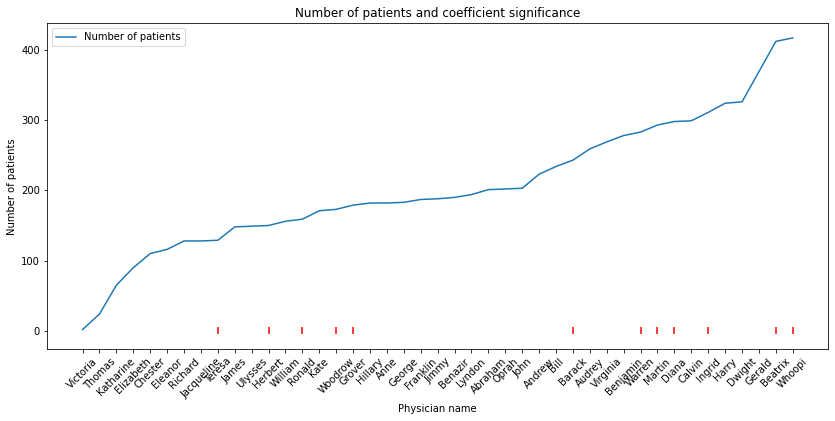

In [42]:
fig, ax = plt.subplots(figsize=(14, 6))

sns.lineplot(data=visits_per_doc, x='phys_name', y='num_patients', sort=False, ax=ax, label='Number of patients');
ax.set_xticklabels(labels=visits_per_doc['phys_name'], rotation=45);

significantly_faster = list(significant_params.index.str.replace("phys_name_", ""))

plt.vlines(significantly_faster, ymin=-5, ymax=5, color='red', label='Significantly faster physicians');
plt.title("Number of patients and coefficient significance");
plt.xlabel("Physician name");
plt.ylabel("Number of patients");

### Robustness to differing specifications {-}

I experiment with removing different combinations of control variables to see if this has any influence on the significance of the physician-specific coefficients.

In [43]:
# first: remove expected visit length 

model = OLS(y, X.drop(columns=['xb_lntdc']))
results = model.fit()

In [44]:
# see if the physician-specific results are different

significant = results.pvalues < 0.05
phys = np.equal(pd.Series(results.params.index).str.slice(0, 4), 'phys')
phys.index = significant.index

significant_params = results.params.loc[(phys) & (significant)].sort_values()
print(significant_params)

phys_name_Diana     -0.391586
phys_name_Teresa    -0.352041
phys_name_Woodrow   -0.341682
phys_name_Barack    -0.317467
phys_name_Herbert   -0.306597
phys_name_Ronald    -0.283669
phys_name_Martin    -0.245592
phys_name_Whoopi    -0.238175
phys_name_Warren    -0.200242
phys_name_Beatrix   -0.192992
phys_name_Ingrid    -0.189328
phys_name_Grover    -0.166252
phys_name_George     0.177066
phys_name_Ulysses    0.207871
dtype: float64


First, I remove expected visit length. I find that the results still largely hold, and our main offenders remain in the final list. However, Diana and Teresa both overtake Woodrow for the top spot. This leads me to believe that Diana and Woodrow take less time per patient on average than Woodrow, but they also tend to be given less severe patients, which is why they overtake Woodrow when we leave out expected visit length.

In [45]:
# second: remove shift length

model = OLS(y, X.drop(columns=['shift_length']))
results = model.fit()

In [46]:
# see if the physician-specific results are different

significant = results.pvalues < 0.05
phys = np.equal(pd.Series(results.params.index).str.slice(0, 4), 'phys')
phys.index = significant.index

significant_params = results.params.loc[(phys) & (significant)].sort_values()
print(significant_params)

phys_name_Woodrow      -0.378458
phys_name_Diana        -0.352952
phys_name_Barack       -0.303172
phys_name_Herbert      -0.293379
phys_name_Teresa       -0.291136
phys_name_Ronald       -0.282891
phys_name_Martin       -0.258019
phys_name_Whoopi       -0.230901
phys_name_Warren       -0.202226
phys_name_Ingrid       -0.183010
phys_name_Jacqueline   -0.170407
phys_name_Grover       -0.164263
phys_name_Beatrix      -0.159329
dtype: float64


Second, I remove shift length. This does not have a huge impact on the final results, and Woodrow remains the top offender. One extra physician is added to the list.

In [47]:
# finally: remove average patients per hour

model = OLS(y, X.drop(columns=['average_patients_per_hr']))
results = model.fit()

In [48]:
# see if the physician-specific results are different

significant = results.pvalues < 0.05
phys = np.equal(pd.Series(results.params.index).str.slice(0, 4), 'phys')
phys.index = significant.index

significant_params = results.params.loc[(phys) & (significant)].sort_values()
print(significant_params)

phys_name_Woodrow      -0.449563
phys_name_Diana        -0.431962
phys_name_Ronald       -0.365070
phys_name_Barack       -0.359734
phys_name_Herbert      -0.359651
phys_name_Teresa       -0.353423
phys_name_Martin       -0.336965
phys_name_Whoopi       -0.269590
phys_name_Jacqueline   -0.244251
phys_name_Ingrid       -0.235036
phys_name_Warren       -0.226953
phys_name_Grover       -0.194019
phys_name_Franklin     -0.177177
phys_name_Beatrix      -0.174223
phys_name_Richard      -0.167452
phys_name_Bill         -0.167399
phys_name_Audrey       -0.135740
dtype: float64


Finally, I remove average number of patients per hour. This results in 6 physicians being added to the list, although Woodrow remains in the top spot.

I conclude that my result of Woodrow being the "worst offender" is relatively robust to differing specifications.